# <center> Project - 3. Booling

## Постановка задачи

Представьте, что вы работаете дата-сайентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.

# Выбор библиотек

In [19]:
# Базовые библиотеки
import pandas as pd
import numpy as np

# Визуализация
import seaborn as sns
import matplotlib.pyplot as plt

# Машинное обучение
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import chi2, f_classif
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import mean_absolute_percentage_error

# Дополнительные инструменты
import time
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from IPython.display import display
import re
from collections import Counter
import ast

# Фиксируем random seed для воспроизводимости
RANDOM_SEED = 42

# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# Загрузка данных
df_train = pd.read_csv('booking_data/hotels_train.csv')  # Датасет для обучения
df_test = pd.read_csv('booking_data/hotels_test.csv')    # Датасет для предсказания
sample_submission = pd.read_csv('booking_data/submission.csv')  # Пример submission

# Помечаем данные для обучения и теста
df_train['sample'] = 1  # Тренировочные данные
df_test['sample'] = 0   # Тестовые данные
df_test['reviewer_score'] = 0  # Заполняем целевой признак нулями для теста

# Объединяем данные
hotels = pd.concat([df_train, df_test], ignore_index=True, sort=False)

In [2]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

В столбцах lat и lng имеются пропуски.

## Очистка данных

### Очистка от дупликатов

In [3]:
# Проверка на дубликаты
print('Количество дубликатов:', hotels.duplicated().sum())

# Удаление дубликатов
hotels = hotels.drop_duplicates()
print('Размер таблицы после удаления дубликатов:', hotels.shape)

Количество дубликатов: 336
Размер таблицы после удаления дубликатов: (515402, 18)


## Проектирование признаков

### Создание новых признаков

##### Признаки времени

In [4]:
# Преобразуем review_date в datetime
hotels['review_date'] = pd.to_datetime(hotels['review_date'])

# Создаем новые признаки: год и месяц
hotels['review_year'] = hotels['review_date'].dt.year
hotels['review_month'] = hotels['review_date'].dt.month

# Преобразуем days_since_review в числовой формат
hotels['days_since_review'] = hotels['days_since_review'].str.extract(r'(\d+)').astype(int)

##### Тэги

In [5]:
# Функция для извлечения тегов
def extract_tags(tags_str):
    try:
        return ast.literal_eval(tags_str)
    except (ValueError, SyntaxError):
        return []

# Применяем функцию к столбцу с тегами
hotels['tags'] = hotels['tags'].apply(extract_tags)

# Собираем все теги в один список
all_tags = [tag for sublist in hotels['tags'] for tag in sublist]

# Считаем частоту тегов
tag_counts = pd.Series(all_tags).value_counts()

# Выводим топ-50 самых частых тегов
print("Топ 50 самых частых тегов:")
print(tag_counts.head(50))

Топ 50 самых частых тегов:
Leisure trip                       417513
Submitted from a mobile device     307458
Couple                             252117
Stayed 1 night                     193557
Stayed 2 nights                    133846
Solo traveler                      108468
Stayed 3 nights                     95754
Business trip                       82880
Group                               65357
Family with young children          60986
Stayed 4 nights                     47774
Double Room                         35207
Standard Double Room                32246
Superior Double Room                31359
Family with older children          26331
Deluxe Double Room                  24810
Double or Twin Room                 22393
Stayed 5 nights                     20825
Standard Double or Twin Room        17478
Classic Double Room                 16865
Superior Double or Twin Room        13570
2 rooms                             12382
Stayed 6 nights                      9762
Standar

Большое количество уникальных тегов. Нужно выбрать самые популярные

In [6]:
tags_series = pd.Series(
    data=all_tags,
    index=all_tags,
    name='tags_series'
)
print("\\nТоп 50 самых частых тэгов:", "\\n")
print(tags_series.value_counts()[:50])

\nТоп 50 самых частых тэгов: \n
tags_series
Leisure trip                       417513
Submitted from a mobile device     307458
Couple                             252117
Stayed 1 night                     193557
Stayed 2 nights                    133846
Solo traveler                      108468
Stayed 3 nights                     95754
Business trip                       82880
Group                               65357
Family with young children          60986
Stayed 4 nights                     47774
Double Room                         35207
Standard Double Room                32246
Superior Double Room                31359
Family with older children          26331
Deluxe Double Room                  24810
Double or Twin Room                 22393
Stayed 5 nights                     20825
Standard Double or Twin Room        17478
Classic Double Room                 16865
Superior Double or Twin Room        13570
2 rooms                             12382
Stayed 6 nights                 

Заполняем пропуски координатами

In [7]:
# Заполняем пропущенные значения через словарь
start_time = time.time()

coord_dict = {
    'Fleming s Selection Hotel Wien City':[48.209095, 16.354568],
    'Hotel City Central':[48.213560, 16.379923],
    'Hotel Atlanta':[48.220310, 16.355880],
    'Maison Albar Hotel Paris Op ra Diamond':[48.875140, 2.323420],
    'Hotel Daniel Vienna':[48.188835, 16.383810],
    'Hotel Pension Baron am Schottentor':[48.216705, 16.359820],
    'Austria Trend Hotel Schloss Wilhelminenberg Wien':[48.219555, 16.285566],
    'NH Collection Barcelona Podium':[41.391430, 2.177890],
    'Derag Livinghotel Kaiser Franz Joseph Vienna':[48.245914, 16.341188],
    'City Hotel Deutschmeister':[48.220856, 16.366642],
    'Holiday Inn Paris Montmartre':[48.888860, 2.333190],
    'Hotel Park Villa':[48.233495, 16.345556],
    'Cordial Theaterhotel Wien':[48.209530, 16.351515],
    'Roomz Vienna':[48.22201, 16.39331],
    'Mercure Paris Gare Montparnasse':[48.839701, 2.323519],
    'Hotel Advance':[41.38322, 2.16295],
    'Renaissance Barcelona Hotel':[41.392430, 2.167500]
}

# Функция для заполнения координат
def fill_coordinates(row):
    if pd.isna(row['lat']):
        if row['hotel_name'] in coord_dict:
            row['lat'], row['lng'] = coord_dict[row['hotel_name']]
    return row

# Применяем функцию к датафрейму
hotels = hotels.apply(fill_coordinates, axis=1)

# Проверяем наличие пропусков
print('Количество пропусков в lat:', hotels['lat'].isna().sum())
print('Количество пропусков в lng:', hotels['lng'].isna().sum())

Количество пропусков в lat: 0
Количество пропусков в lng: 0


In [8]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
Index: 515402 entries, 0 to 515737
Data columns (total 20 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515402 non-null  object        
 1   additional_number_of_scoring                515402 non-null  int64         
 2   review_date                                 515402 non-null  datetime64[ns]
 3   average_score                               515402 non-null  float64       
 4   hotel_name                                  515402 non-null  object        
 5   reviewer_nationality                        515402 non-null  object        
 6   negative_review                             515402 non-null  object        
 7   review_total_negative_word_counts           515402 non-null  int64         
 8   total_number_of_reviews                     515402 non-null  int64         
 9 

Пропусков больше нет.

#### Выведем названия стран отеля

In [9]:
def get_country(hotel_address):
    
    "endswith('Kingdom'): Проверяем, заканчивается ли адрес на слово 'Kingdom'. Если да, то возвращаем последние два слова."
    "split()[-1]: Если адрес не заканчивается на 'Kingdom', просто возвращаем последнее слово."
    
    if hotel_address.endswith('Kingdom'):
        return ' '.join(hotel_address.split()[-2:])
    return hotel_address.split()[-1]

hotels['country'] = hotels['hotel_address'].apply(get_country)
hotels['country'].value_counts()

country
United Kingdom    262299
Spain              60149
France             59598
Netherlands        57212
Austria            38938
Italy              37206
Name: count, dtype: int64

#### Создадим признаки на основе информации в тегах.

In [10]:
# 1. Объединение тегов
hotels['tags'] = hotels['tags'].apply(lambda x: '_'.join(x))

# 2. Типы размещения
type_of_placement = ['Single', 'Double', 'Twin', 'Triple']
for tag in type_of_placement:
    hotels[f'tag_{tag}'] = hotels['tags'].apply(lambda x: int(tag in x))

# 3. Уровень комфорта
comfort_level = ['Standard', 'Junior Suite', 'Suite', 'Deluxe', 'Duplex', 'Studio']
for tag in comfort_level:
    if tag == 'Suite':
        hotels['tag_Suite'] = hotels['tags'].apply(lambda x: int('Suite' in x and 'Junior Suite' not in x))
    elif tag == 'Junior Suite':
        hotels['tag_Junior_Suite'] = hotels['tags'].apply(lambda x: int('Junior Suite' in x))
    else:
        hotels[f'tag_{tag}'] = hotels['tags'].apply(lambda x: int(tag in x))

# 4. Количество ночей
def get_num_of_nights(tags):
    # Проверяем, есть ли в тегах информация о количестве ночей
    if 'Stayed' in tags:
        try:
            # Извлекаем количество ночей
            nights_part = tags.split('Stayed_')[1]  # Получаем часть строки после 'Stayed_'
            nights = int(nights_part.split('_')[0])  # Извлекаем первое число
            return str(nights) if nights < 4 else '>3'
        except (IndexError, ValueError):
            # Если что-то пошло не так (например, формат тега неверный), возвращаем None
            return None
    return None

# Применяем функцию к столбцу tags
hotels['Stayed'] = hotels['tags'].apply(get_num_of_nights)

#### Добавим признаки, которые могут быть полезны для модели (например, длина отзывов, количество слов в отзывах).

In [11]:
# Длина отзывов
hotels['negative_review_length'] = hotels['negative_review'].apply(len)
hotels['positive_review_length'] = hotels['positive_review'].apply(len)

# Количество слов в отзывах
hotels['negative_review_word_count'] = hotels['negative_review'].apply(lambda x: len(x.split()))
hotels['positive_review_word_count'] = hotels['positive_review'].apply(lambda x: len(x.split()))

#### Удаляем не нужные признаки

In [12]:
# Удаляем неинформативные признаки
columns_to_drop = [
    'hotel_address', 'review_date', 'hotel_name', 'reviewer_nationality',
    'negative_review', 'positive_review', 'tags', 'country'
]
hotels = hotels.drop(columns=columns_to_drop)

# Преобразуем категориальные признаки в числовые (one-hot encoding)
categorical_columns = ['Stayed']  # Пример категориального признака
hotels = pd.get_dummies(hotels, columns=categorical_columns, drop_first=True)

# Заполняем пропущенные значения (если есть)
hotels = hotels.fillna(0)

# Убедимся, что все признаки числовые
hotels = hotels.apply(pd.to_numeric, errors='ignore')

# Отделяем целевую переменную
X = hotels.drop(columns=['reviewer_score'])  # Признаки
y = hotels['reviewer_score']  # Целевая переменная

C:\Users\User\AppData\Local\Temp\ipykernel_14384\2671039988.py:16: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  hotels = hotels.apply(pd.to_numeric, errors='ignore')


In [13]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
Index: 515402 entries, 0 to 515737
Data columns (total 27 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515402 non-null  int64  
 1   average_score                               515402 non-null  float64
 2   review_total_negative_word_counts           515402 non-null  int64  
 3   total_number_of_reviews                     515402 non-null  int64  
 4   review_total_positive_word_counts           515402 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515402 non-null  int64  
 6   reviewer_score                              515402 non-null  float64
 7   days_since_review                           515402 non-null  int64  
 8   lat                                         515402 non-null  float64
 9   lng                                         515402 non-null  float64
 10  s

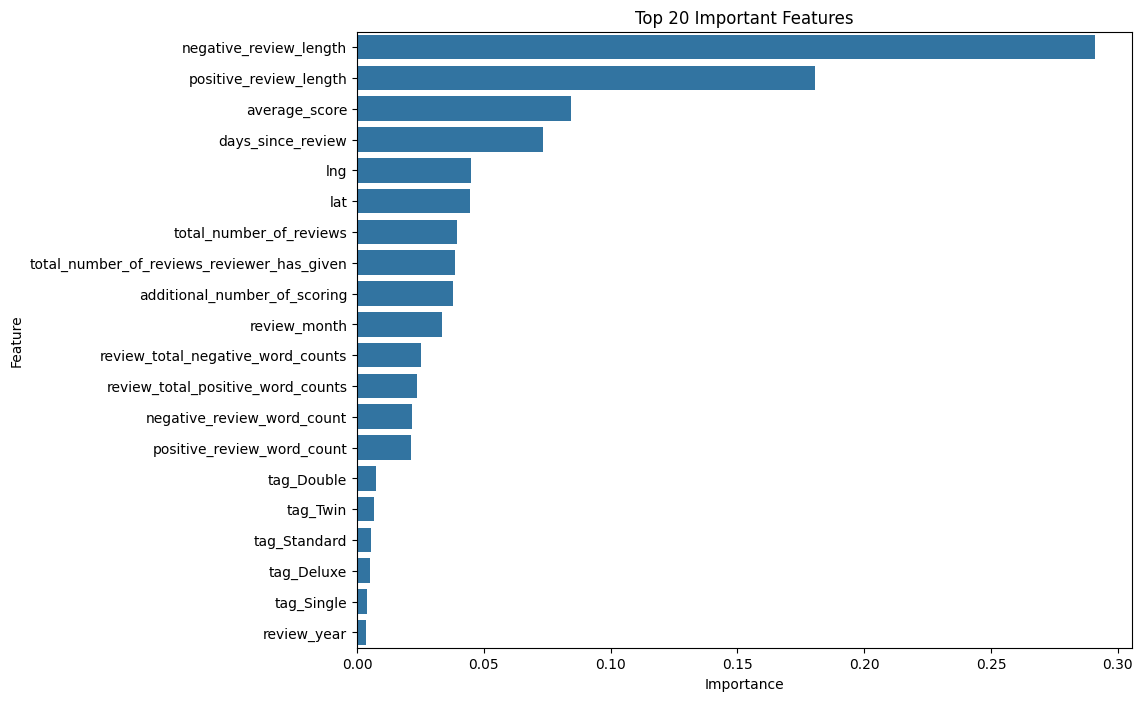

In [21]:
# Получаем важность признаков
feature_importances = model.feature_importances_

# Создаем DataFrame для удобства визуализации
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Сортируем признаки по важности
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Визуализация
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))  # Топ-20 признаков
plt.title('Top 20 Important Features')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## Построение модели

In [14]:
# Выделение обучающих и тестовых данных
# Выделяем обучающие данные, где 'sample' == 1 (train) и удаляем колонку 'sample'
train_data = hotels.query('sample == 1').drop(['sample'], axis=1)

# Выделяем тестовые данные, где 'sample' == 0 (test) и удаляем колонку 'sample'
test_data = hotels.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values

# Обучающие данные (все признаки, кроме целевой переменной 'reviewer_score')
X = train_data.drop(['reviewer_score'], axis=1)

# Разделение данных на обучающие и валидационные
# Выделим 20% данных на валидацию (параметр test_size)
split_percent = 0.2

# Воспользуемся функцией train_test_split для разбиения данных на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_percent, random_state=RANDOM_SEED)

# Проверяем размеры выборок
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

# Создание и обучение модели RandomForestRegressor
# Создаем модель RandomForestRegressor
# Параметры: 100 деревьев, многопоточность (-1 для использования всех ядер CPU), фиксированное состояние random_state
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

# Обучаем модель на обучающих данных
model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.2min finished


RandomForestRegressor(n_jobs=-1, random_state=42, verbose=1)

In [15]:
# Предсказание на валидационной выборке
# Используем обученную модель для предсказания рейтингов на тестовой выборке
y_pred = model.predict(X_test)

# Выбираем случайные 10 строк для просмотра
test_data.sample(10)

# Предсказание на тестовой выборке для отправки на Kaggle
# Удаляем столбец 'reviewer_score' из тестовой выборки, так как это значение мы будем предсказывать
test_data = test_data.drop(['reviewer_score'], axis=1)

# Предсказание на тестовых данных
predict_submission = model.predict(test_data)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.6s finished


In [20]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test) и смотрим, насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений в отношении фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.13192875702211343
